# 긍정, 부정 감성 분석

+ 문장의 긍정/부정을 분류
+ 영화 리뷰나 음식점 리뷰등을 통해 긍정/부정 라벨링 적용


+ 네이버의 박은정 박사 2015년에 발표한 긍정/부정 감성 분석
+ 총 20만개의 리뷰중에서 훈련 데이터 15만개 테스트 데이터 5만개
+ 리뷰 중 10만개는 별점이 1-4로 부정적인 리뷰이고, 나머지 10만개는 별점이 9-10점으로 긍정적인 리뷰이다.
  ( 벌점이 5-8인 중립적인 리뷰는 포함하지 않는다)
  
  
+ 참고사이트
    - https://github.com/e9t/nsmc
    - https://www.lucypark.kr/docs/2015-pyconkr/#38


In [1]:
import numpy as np
import tensorflow as tf

In [2]:
# (1) 데이타 다운로드 ( Naver Sentiment Movie Corpus v1.0 )
#path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
#path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

In [3]:
# (2) 데이터 로드 및 확인
# 데이터를 메모리에 불러옵니다. encoding 형식으로 utf-8 을 지정해야합니다.
#train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
#test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

train_text = open('./dataset/train.txt', 'rb').read().decode(encoding='utf-8')
test_text = open('./dataset/test.txt', 'rb').read().decode(encoding='utf-8')

# 텍스트가 총 몇 자인지 확인합니다.
print('Length of text: {} characters'.format(len(train_text)))
print('Length of text: {} characters'.format(len(test_text)))
print()

# 처음 300 자를 확인해봅니다.
print(train_text[:300])

# 데이타의 각 행은 /t으로 구분되어 있다
# label 에서 0은 부정, 1은 긍정을 의미한다

Length of text: 6937271 characters
Length of text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [4]:
# (3) 학습을 위한 훈련 데이타와 테스트 데이타 만들기
#      (3-1) 정답 데이터(Y)를 먼저 만들기
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [5]:
# (3) 학습을 위한 훈련 데이타와 테스트 데이타 만들기
#     (3-2) 훈련 데이터의 입력(X)에 대한 정제(Cleaning) - 불필요한 기호등을 제거

import re
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py  ( 김윤 박사의 CNN_sentence 함수 코드 )
# 패턴을 나타내는 문자열 r'파이썬' 앞에 r이 붙어 있다. 패턴에는 다양한 기호가 포함되는데 이스케이프가 되면 곤란할 때가 많다. 
# 문자열 앞에 r을 붙여 이스케이프(특별의미)를 방지하는 편이 좋다

# 각종 기호를 단어와 분리?
def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)  # ^ : []안에 포함되지 않은 그 외것을 선택
    # 위 코드로 ,!? 기호 외의 특수 기호 제거 (.은 제거됨)
    # 아래코드는 단어와 붙은 기호를 단어와 분리(하나의 단어처럼 취급하도록 앞 뒤로 공백 추가)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()


train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

# 문장을 띄어쓰기 단위로 단어 분리 ( .,'" 등의 점이 없어짐 )
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


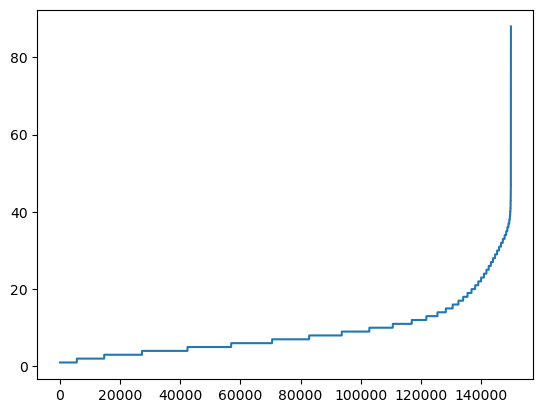

142587


In [6]:
# (3-3) 각 문장의 단어 길이 확인
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

# [결과] 15만개 문장중 40 단어 이하로 주로 구성되어 있음을 확인
#        특히 25단어 이하의 문장이 전체의 142587개로 95% 정도이다.

In [7]:
# (3-4) 단어 정제 및 문장 길이 줄임
#       예를 들어, 스파이더맨, 스파이더맨이, 스파이더맨을, 스파이더맨에게 등등을 5글자로 줄이면 '스파이더맨'이 된다.
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [8]:
# (3-5) Tokenizer와 pad_sequences를 사용한 문장 전처리
#       Tokenizer(num_words) : 데이터에 출현하는 모든 단어의 갯수를 세고 빈도 수를 정렬하여 num_words 수만큼 반환하고 나머지는 0으로 반환한다.
#                              즉, 빈도 높은 단어순으로 num_words 개 반환
#       tokenizer.fit_on_texts(sentences) : Tokenizer에 데이타를 실제로 입력한다.
#       tokenizer.texts_to_sequences(sentences) : 문장을 입력받아 숫자로 반환
#       pad_sequences() : 입력된 데이터에 패팅을 더함

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
train_X = pad_sequences(train_X, padding='post')  # post: 뒤에, pre: 앞에

print(train_X[:5])


[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]



[결과]

+ '아'글자가 25로 '더빙'은 884라는 숫자로 변경하면서 나머지는 0으로 25개의 리스트됨
         ['아', '더빙', '진짜', '짜증나네요', '목소리'] 
         [   25   884     8  5795  1111     0     0     0     0     0     
             0     0      0     0     0     0     0     0     0     0 
             0     0    0     0       0]
             
+ 세번째 문장 '너무재밓었'는 빈도수 20000개에 들지 못하여 0 처리됨
+ 다섯번째 문장에서도 Tokenizer에 의해 걸려져서 0으로 처리됨

In [9]:
# [참고] 위의 Tokenizer의 동작 확인
#       tokenizer.texts_to_sequences(sentences) : 문장을 입력받아 숫자로 반환
#       pad_sequences() : 입력된 데이터에 패팅을 더함

print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])
temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가'])
print(temp)
temp = pad_sequences(temp, padding='post')
print(temp)

# [결과]
#        19999번째 단어 : '경우는',  20000번째 단어 : '잊혀질'
#       확인후 '경우는' -> 19999, '잊혀질' -> 0 으로 된다

경우는
잊혀질
[[], [19999], [], [106]]
[[    0]
 [19999]
 [    0]
 [  106]]


## 모델 정의

   - Embedding 레이어와 LSTM 레이어를 연결한 뒤 마지막으로 Dense 레이어의 softmax 활성화 함수를 사용하여 긍정/부정 분류하는 모델
   
   
#### 엠베딩 레이어 (Embedding Layer)    
+ 자연어를 수치화된 정보로 바꾸기 위한 레이어
+ 한정된 길이의 벡터로 자연어의 구성 단위인 자소, 문자 단어, n-gram 등을 표현


` 특정 단어와 맵핑되는 정수를 인덱스로 가지는 테이블로부터 임베딩 벡터 값을 가져오는 룩업 테이블이라고 볼 수 있습니다. 그리고 이 테이블은 단어 집합의 크기만큼의 행을 가지므로 모든 단어는 고유한 임베딩 벡터를 가집니다.
<img src='./imgs/embedding.PNG' >

` [참고] [ 딥 러닝을 이용한 자연어 처리 입문 ](https://wikidocs.net/33793)

In [10]:
# (4) 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
# 임베딩 레이어에서 input_length=25를 지정해서 각 문장에 들어있는 25개 단어를 길이 300의 임베딩벡터로 변환한다.
# 여러 개의 정답 중 하나를 맞추는 분류 문제에서는 categorical_crossentropy를 사용하고, sparse는 정답인 Y가 희소 행렬일 때 사용한다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           6000000   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [11]:
# (5) 모델 학습 ( 시간소요 많음 )
#   batch_size : 데이타의 양
#   validation_split : 20%를 검증데이타로 사용
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)


Epoch 1/5
938/938 [==============================] - 105s 108ms/step - loss: 0.4325 - accuracy: 0.7868 - val_loss: 0.3842 - val_accuracy: 0.8228
Epoch 2/5
938/938 [==============================] - 101s 108ms/step - loss: 0.3241 - accuracy: 0.8466 - val_loss: 0.4060 - val_accuracy: 0.8176
Epoch 3/5
938/938 [==============================] - 105s 112ms/step - loss: 0.2734 - accuracy: 0.8673 - val_loss: 0.4047 - val_accuracy: 0.8188
Epoch 4/5
938/938 [==============================] - 112s 120ms/step - loss: 0.2320 - accuracy: 0.8854 - val_loss: 0.4559 - val_accuracy: 0.8135
Epoch 5/5
938/938 [==============================] - 132s 140ms/step - loss: 0.1979 - accuracy: 0.9015 - val_loss: 0.5243 - val_accuracy: 0.8076


[결과]

        학습 데이타의 loss는 감소하지만, 검증 데이타의 val_loss는 증가한다.
        이는 과적합이 되고 있다는 것이다.

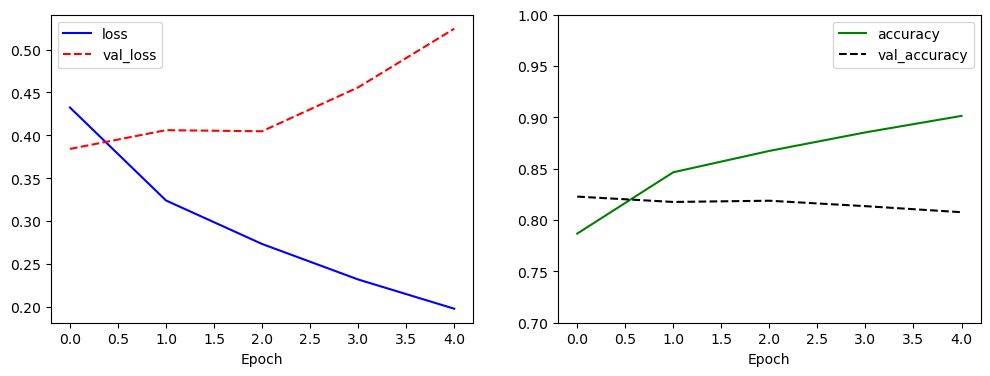

In [12]:
# (6) 모델 학습 결과를 그래프로 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

[ 결과 ]

그래프를 보면 과적합이 확실하다.

과적합의 이유는 임베딩 레이어를 랜덤한 값에서부터 시작해서 학습시키기 때문에 각 단어를 나타내는 벡터의 품질이 좋지 않기 때문이란다.

이를 개선하기 위한 방법으로는 임베딩 레이어를 별로도 학습시켜서 사용하거나 RNN이 아닌 CNN을 사용하는 방법도 있다.

In [13]:
# (7) 테스트 데이터 평가
#     테스트 데이터는 훈련 데이타와 다르게 어떤 단어가 나올지 모르기에 Tokenizer는 훈련 데이터로만 학습시켜야 한다.

# print(test_text[:100])
# 위의 출력으로 확인해 보니 첫줄을 빼고 개행단위로 한 줄씩 row에 넣은 후
# 단어(\t로 구분)의 갯수가 있는 상태에서만
# 첫단어 id값이 아닌 두번째 단어를 test_text_X 에 지정한다
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]

sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

model.evaluate(test_X, test_Y, verbose=0)
# [결과] 테스트 데이타의 정확도가 80%정도로 검증 데이타의 정확도와 비슷하다.

[0.5320173501968384, 0.8002600073814392]

In [14]:
# (8) 임의의 문장 감성 분석 결과 확인
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

1/1 [==============================] - 1s 599ms/step
['재미있을']
[0.41775984 0.58224016]
['재미있을', '줄']
[0.38663 0.61337]
['재미있을', '줄', '알았는데']
[0.3883381 0.6116619]
['재미있을', '줄', '알았는데', '완전']
[0.37266243 0.62733763]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.37266243 0.62733763]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.52651966 0.4734803 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.96651036 0.03348965]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.995836   0.00416393]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.995836   0.00416393]


[ 결과 ]

    ` [0.44566754 0.55433244] : 앞에 45% 부정 뒤에 55%가 긍정
    ` 처음에 '재미있을'이라는 단어만으로는 긍정의 확률이 55%로 부정보다 높다
    ` 이후에 '졸리고'가 들어가면서 부정이 99%로 나오는 것을 알 수 있다